# Generation of simulated HAADF STEM images and multi-elements label maps of HEAs CHs and CHs statistical analysis

In this notebook it is demonstrated how to create simulated HAADF STEM images and the corresponding multi-elements labels maps for training a neural network to predict the atomic column heights (CHs) in multi-components high-entropy alloys (HEAs). The Python classes used to derive the HEAs data are implemented in the file '*make_HEA_data_utils.py*'. In particular, we will use the following classes:

- **ATK_Random_HEA**: generation of a random NiPdCoFe HEAs model in ATK and saved in an .xyz file. In this case the composition is defined when creating the HEA model in ATK. The position of atoms of the five chemical elements is varied randomly to create random structures from a single ATK model. The .xyz ATK files must be stored in a directory named for example 'ATK_structures', and a file could be named for instance structure_1.xyz
 
- **Random_HEA**: generation of random PtNiPdCoFe HEAs model with random positions of the five elements in the structure. The random HEAs models are built on top of the precomputed random nanoparticle models generated using the Random_Cluster class. HEA are typically characterized by non equiatomic compositions, so here we can define a composition for each element, with a random variation in a range. There are two ways to do this:

   - 1. imposing a random composition for each element "manually". In this case, we have to be very careful that the random compositions add to 100%, if not we will receive an error in the structure generation. This is done by imposing that the composition of the last element we assign is 100 - sum(composition of other elements). However, we need to be careful that sum(composition of other elements) < 100. The range of the random composition must be defined carefully!
   
   - 2. imposing a random composition for each elment "algorithmically". In this case, an implemented function assigns a random composition in a range by taking care that all compositions add to 100%. However, in this case, we can not control the composition of each element as in the previous case.
 
 
 
 - **HEA_STEM**: generation of the simulated HAADF STEM images from the precomputed HEA atomic models.
 
 
 - **HEA_Labels**: generation of the label maps of the CHs for each chemical element from the precomputed HEA atomic models.
 
 
 - **HEA_Data**: saving the generated data (HEA model, simulated HAADF STEM images and CHs maps) into numpy files.


A statistical analysis of the CHs distribution for each chemical alement is also included. The objective of this analysis is to evalaute the number of columns of different heights, the columns composition and most importantly the correlation between the column intensity in the simulated STEM image and the column heights by chemical element.
  
We use the following Python libraries: **Numpy**, **Scikit-Image** for image processing, **Atomic Simulation Environment (ASE)** for atomistic modeling and **PyQSTEM** for STEM images simulations.

In [1]:
# Importing the general libraries
import numpy as np
import random
import ase

from ase.visualize import view

from pyqstem import PyQSTEM

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. Generation of simulated HAADF STEM images and multi-elements label maps of HEAs CHs

## 1.1 HEA atomic models

The class **ATK_Random_HEA** is used to generate the atomic models of HEA from an .xyz file representing an atomic model created in ATK. To generate random models from a single .xyz file, the atoms of different chemical elements are shuffled in the structure. The input parameters are:

 - **structure_path**: path to .xyz file to load.
 
 - **spatial domain**: it is very important to train the neural network on images wich represent a physical domain with the same size of the experimental measurements, unless the applications of the network on experimental images will not work. In our applications, the represented spatial domain is 51.2 A.
 
 - **random_transl**: if we want a random translation along the x an y axis, set to True, if not, set to False
  
- **t_xy**: fraction of the computational domain by wich the HEA model is randomly translated. By defautl, the HEA model is placed in the center at x,y = 0, if the translation is applied. The HEA is translated between [-t_xy * comp. domain,+t_xy * comp. domain] along the x and y directions

 - **random_rot**: if we want a random rotation around the y axis, set to True, if not, set to False.
 
 - **a_y**: list of angles to be picked randomly to rotate the HEA model around the y axis.

The class **Random_HEA** is used to generate the atomic models of HEA characterized by a random composition of five chemical elements: Pt, Ni, Pd, Co and Fe. The HEA models are built using appropriate modules of the **ASE** library. The input parameters are:

 - **crystal_structure**: crystal structure of the HEA atomic model. In this application, we consider FCC solid solutions HEAs. 
 
 
 - **random_size**: we generate HEA with a random size, selected in a range in agreement with the HEAs in the experimental images. In this way, the neural network will be trained on images representing HEAs with the same size of the experimental measurements.
 
 - **chemical_symbols**: chemical symbols of the elememts in the HEA structure. In our application we consider Pt,Ni,Pd,Co and Fe. The HEA models will be created with a random distribution of the five elements in the structure.
 
 - **comp**: chemical composition of the HEA model. Of we want a specific composition, we can assign it manually as a list of the composition of each of the chemical elements. If not, set it to 'random', so that the composition is computed algorithmically to be random between a lower and upper bound.
 
 - **low_compo,high_comp**: lower and upper bound of the chemical compositions. Used if comp = 'random', ignored otherwise. If we consider as lower bound 5% and upper bound 45%, a random composition could be Pt5Ni20,Pd30,Co25,Fe20 

In [2]:
# importing the library
import sys
sys.path.append('./scripts/')

from make_HEA_data_utils import*

In [3]:
# defining the input parameters
crystal_structure = 'fcc'

ATK_structure = False
ATK_path = 'ATK_structures/'

# size of the crystal structure
#random_size = np.random.uniform(65,75) #A
low_size = 28
up_size = 35

# spatial domain represented in the image
#spatial_domain = (51.2, 51.2) #A
spatial_domain = (50, 50) #A

# flag to impose a random translation of the HEA NP in the x,y directions
random_transl = True
t_xy = 1/8
random_rot = True
a_y = [0, 45, 90, 135, 180, 225, 270, 315]

# chemical symbols of the considered elements
chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

# set the composition of each element "manually"
low_comp_Pt = ...
high_comp_Pt = ...

low_comp_Ni = ...
high_comp_Ni = ...

low_comp_Pd = ...
high_comp_Pd = ...

low_comp_Co = ...
high_comp_Co = ...

low_comp_Fe = ...
high_comp_Fe = ...

# set the composition of each element "randomly"
comp = 'random'

low_comp = 18  # lower bound of element composition
high_comp = 20  # upper bound of element composition

In [4]:
if ATK_structure:
    

    #structure_path = 'atomic_structures/structure_{}.xyz'.format(random.choice([1,2,3,4,5,6,7]))
    structure_path = os.path.join(ATK_path,'/structure_{}.xyz'.format(3))
    
    print('Creating random HEA model from VTK xyz file: {}..'.format(structure_path))

    random_HEA = ATK_Random_HEA(structure_path,
                                spatial_domain,
                                random_transl,
                                t_xy,
                                random_rot,
                                a_y)

    random_HEA_model = random_HEA.get_model()

    cs = np.array(random_HEA_model.get_chemical_symbols())

    Pt_idx = np.where(cs == 'Pt')[0]
    Ni_idx = np.where(cs == 'Ni')[0]
    Pd_idx = np.where(cs == 'Pd')[0]
    Co_idx = np.where(cs == 'Co')[0]
    Fe_idx = np.where(cs == 'Fe')[0]

    cs_list = list(cs[Pt_idx]) + list(cs[Ni_idx] + list(Pd_idx) + list(Co_idx) + list(Fe_idx))
    random.shuffle(cs_list)
    
    cs_idx = len(Pt_idx)
    cs[Pt_idx] = cs_list[:cs_idx]

    cs[Ni_idx] = cs_list[cs_idx:cs_idx + len(Ni_idx)]
    cs_idx = cs_idx + len(Ni_idx)
    
    cs[Pd_idx] = cs_list[cs_idx:cs_idx + len(Pd_idx)]
    cs_idx = cs_idx + len(Pd_idx)
    
    cs[Co_idx] = cs_list[cs_idx:cs_idx + len(Co_idx)]
    cs_idx = cs_idx + len(Co_idx)
    
    cs[Fe_idx] = cs_list[cs_idx:cs_idx + len(Fe_idx)]
    cs_idx = cs_idx + len(Fe_idx)
    
    random_HEA_model.set_chemical_symbols(cs)

else:
    

    random_size = np.random.uniform(low_size,up_size)  # A

    if comp is not 'random':
        
        print('Creating random HEA model from Random_Cluster and imposed compositions..')
        
        comp_Pt = np.random.uniform(low_comp_Pt, high_comp_Pt)  # composition element 1
        comp_Ni = np.random.uniform(low_comp_Ni, high_comp_Ni)  # composition element 2
        comp_Pd = np.random.uniform(low_comp_Pd, high_comp_Pd)  # composition element 3
        comp_Co = np.random.uniform(low_comp_Co, high_comp_Co)  # composition element 4
        comp_Fe = 100 - comp_Pt - comp_Ni - comp_Pd - comp_Co # composion element 5

        comp = [comp_Pt,comp_Ni,comp_Pd,comp_Co,comp_Fe]
    
        assert len(chemical_symbols) == len(comp), '{} fractions are required for {} chemical symbols'.format(len(chemical_symbols),
                                                                                                              len(chemical_symbols))
    else:
        
        print('Creating random HEA model from Random_Cluster and and random compositions between {}% and {}%..'.format(low_comp,high_comp))

    # creating the object random_HEA of the class Random_HEA
    random_HEA = Random_HEA(crystal_structure,
                            random_size,
                            spatial_domain,
                            random_transl,
                            t_xy,
                            random_rot,
                            a_y,
                            chemical_symbols,
                            comp,
                            low_comp,
                            high_comp)
    
    # generating the HEA model using the method 'get_model' of the Random_HEA class
    random_HEA_model = random_HEA.get_model()
    
print('Pt composition: {:.1f}%'.format(100 * len(np.where(np.array(random_HEA_model.get_chemical_symbols()) == 'Pt')[0]) / len(random_HEA_model.get_chemical_symbols())))
print('Ni composition: {:.1f}%'.format(100 * len(np.where(np.array(random_HEA_model.get_chemical_symbols()) == 'Ni')[0]) / len(random_HEA_model.get_chemical_symbols())))
print('Pd composition: {:.1f}%'.format(100 * len(np.where(np.array(random_HEA_model.get_chemical_symbols()) == 'Pd')[0]) / len(random_HEA_model.get_chemical_symbols())))
print('Co composition: {:.1f}%'.format(100 * len(np.where(np.array(random_HEA_model.get_chemical_symbols()) == 'Co')[0]) / len(random_HEA_model.get_chemical_symbols())))
print('Fe composition: {:.1f}%'.format(100 * len(np.where(np.array(random_HEA_model.get_chemical_symbols()) == 'Fe')[0]) / len(random_HEA_model.get_chemical_symbols())))

print('Done!')

Creating random HEA model from Random_Cluster and and random compositions between 18% and 20%..
Pt composition: 20.0%
Ni composition: 19.0%
Pd composition: 18.0%
Co composition: 19.0%
Fe composition: 24.0%
Done!


We can check some properties of the HEA model. For example:

- **chemical composition**:

In [5]:
random_HEA_model.get_chemical_formula()

'Co410Fe517Ni409Pd388Pt431'

- **atomic number and mass**:

In [6]:
print('atomic numbers: {}'.format(np.unique(random_HEA_model.get_atomic_numbers())))
print('')
print('masses: {}'.format(np.unique(random_HEA_model.get_masses())))

atomic numbers: [26 27 28 46 78]

masses: [ 55.845     58.6934    58.933194 106.42     195.084   ]


In [7]:
#random_HEA_model.get_positions().shape

#chem = []

#for i in range(len(random_HEA_model.get_positions())):
#    chem.append('Fe')
#random_HEA_model.set_chemical_symbols(chem)

In [8]:
view(random_HEA_model)

In [9]:
np.unique(random_HEA_model.get_chemical_symbols())

array(['Co', 'Fe', 'Ni', 'Pd', 'Pt'], dtype='<U2')

In [10]:
#view(random_HEA_model,viewer = 'x3d')

## 1.2 Simulated HAADF STEM images

The class **HEA_STEM** is used to generate the simulated HAADF STEM images using the multislice algorithm implemented in the PyQSTEM library. The input parameters are:

- **qstem**: object of the class PyQSTEM in STEM mode. The qstem object contains all the modules necessary to simulate the HAADF STEM images.


- **random_HEA_model**: atomic model of the random HEA structure generated by the Random_HEA class.


- **image_size**: size of the simulated images. We consider 256 x 256 images. The experimental images are 512 x 512, but setting correctly the resolution allows to represent the same spatial domain of 51.2 x 51.2 [A].


- **resolution**: amount of A represented in 1 pixel [A/px]. The resolution is equal to the spatial_domain [A] divided by the size of the image [px]. Since we have a spatial domain of 51.2 x 51.2 [A] and an image size of 256 x 256 [px], the resolution is 51.2 A/256 px = 0.2 [A/px]. The experimental images are 512x512 px, thus the resolution over a spatial domain of 51.2 [A] is 0.1 [A/px]. It is essential to generate simulated images with a resolution which is scaled to image size, in order to preserve the same spatial dimensionality.



- **probe**: size of the probe. We consider 8 [nm] (80 [A]) in agreement with the expetimental measurements.


- **slice_thickness**: slice thickness in the STEM simulations. We found that a slice thickness of 0.2 [nm] (2 [A]) is sufficiently refined for a probe size of 8 [nm] (80 [A]). The resulting number of slices is 40.

**Microscope Parameters**: STEM microscope parameters, randomly picked in a range in agreement with the experimental conditions.

- **random_v0**: acceleration voltage [keV].


- **random_alpha**:  convergence_angle [mrad].


- **random_defocus**:  defocus [A].


- **random_Cs**:  1st order aberration.


- **random_asti_mag**: astigmation magnitude [A].


- **random_asti_angle**: astigmation angle [A].

Experimental images are typically affected by a certain degree of noise. We add some random noise with the following parameters:


- **add_noise**: True (or False). Whether or not adding noise to the simulated image.


- **noise_mean**: the noise is created using a random Gaussian distirbution with mean noise_mean.


- **noise_std**: the noise is created using a random Gaussian distirbution with standard deviation noise_std.

In [11]:
# importing the library
from make_HEA_data_utils import  HEA_STEM

In [12]:
# defining the input parameters

qstem = PyQSTEM('STEM')

# pixel size of the image
image_size = (256,256) # [px]

# image atomic resolution 
resolution = spatial_domain[0]/image_size[0]  # [A/px]

# microscope parameters for STEM image simulation using the multislice algorithm
probe = 8 # probe size [nm]
    
slice_thickness = 0.8 # [nm]
    
random_v0 = np.random.uniform(180, 220)  # acceleration voltage [keV]

random_alpha = np.random.uniform(15, 20)  # convergence_angle [mrad]

random_defocus = np.random.uniform(-10, 10)  # defocus [A]

random_Cs = np.random.uniform(180, 220, size=1)[0]  # 1st order aberration

random_astig_mag = np.random.uniform(18, 22)  # astigmation magnitude [A]

random_astig_angle = np.random.uniform(12, 16) # astigmation angle [A]

random_aberrations = {'a33': 0, 'phi33': 30} 

# random noise parameters
add_noise = True # depending if we want to add noise in the simulated STEM image

noise_mean = 0.0 # noise distribution mean (noise added is add_noise = True)

noise_std = 1.0  # noise distribution std (noise added is add_noise = True)

In [13]:
# creating the object HEA_stem of the class HEA_STEM


HEA_stem = HEA_STEM(qstem,
                    random_HEA_model, 
                    image_size,
                    resolution, 
                    probe,
                    slice_thickness, 
                    random_v0, 
                    random_alpha, 
                    random_defocus,
                    random_Cs,
                    random_astig_mag,
                    random_astig_angle,
                    random_aberrations,
                    add_noise,
                    noise_mean,
                    noise_std)

# generating the simulated HAADF STEM image using the 'get_HEA_stem' method
print('Computing STEM simulated image..')
img = HEA_stem.get_HEA_stem()
print('Done!')

Computing STEM simulated image..
Done!


## 1.3 Column Heights Labels

The class **HEA_Labels** is used to generate the column heights maps for each chemical element in the HEA structure. The CHs maps are created with a Gaussian distribution centered in the column's peaks and decreasing with continuity towards the background. The continuity of the pixel's values is essential for the implementation of a regression-based prediction of the CHs.


A label map is created for each chemical element in the HEA structure. Thus, we have five label maps for Pt,Ni,Pd,Co and Fe. The input parameters are:


 - **random_HEA_model**: HEA atomic model generated with the Random_HEA class.
 
 
 - **image_size**: the size of the label maps must be the same of the input image, since the deep learning model is a fully convolutional network (FCN) with a symmetrical structure of the encoder and decoder blocks.
 
 
 - **resolution**: the label maps must be created with the same resolution of the input image in order to preserve the represented spatial dimensionality.
 
 - **spotsie**: size of the Gaussian distribution spot representing the column



In [14]:
# importing the library

from make_HEA_data_utils import HEA_Labels

In [15]:
# creating the object HEA_labels of the class HEA_Labels
# for creating the CHs labels of the HEA atomic model
# according to the imposed image size and resolution

spot_size = 0.4

HEA_labels = HEA_Labels(random_HEA_model,
                        image_size,
                        resolution,
                        spot_size)

# generating the CHs label maps for each chemical element
lbl = HEA_labels.get_labels_multi_elements()

- **load the data from folder so we don't need to run the code (it takes ~20 minutes to simulated model and image)**

In [16]:
#img = np.load('training_data/data/data_17798.npy')[0,:,:,0]
#lbl = np.load('training_data/data/data_1.npy')[0,:,:,1:]

## 1.4 Plots of the simulated HAADF STEM image and label maps|

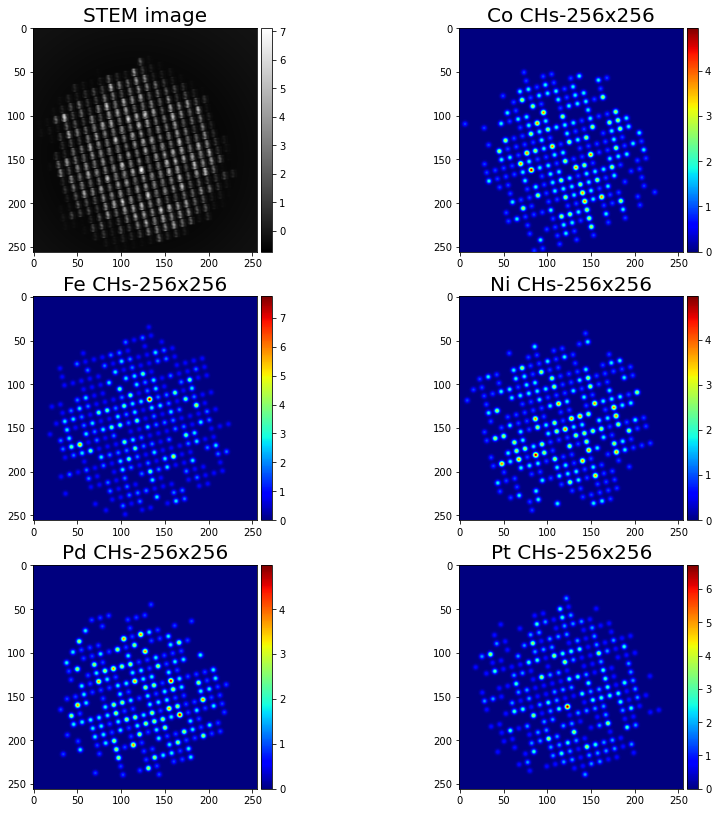

In [17]:
chemical_symbols = list(np.unique(random_HEA_model.get_chemical_symbols()))


fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(3, 2, 1)
im = ax.imshow(img, cmap='gray')
plt.title('STEM image', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

for cs in range(1,len(chemical_symbols) + 1):

    ax = fig.add_subplot(3, 2, cs + 1)
    im = ax.imshow(lbl[:, :, cs - 1], cmap='jet')
    plt.title('{} CHs-{}x{}'.format(chemical_symbols[cs - 1],image_size[0],image_size[1]), fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)



## 1.5 Saving the data

The class **HEA_Data** is used to save the simulated data (i.e., simulated HAADF STEM image and CHs label maps) into a training/test directory. Since the input image and the label maps have the same size, **they are concatenated into a single variable and saved into a single and multi-channel numpy array (tensor) and labeled with the index 'data_index'** . The input parameters are:


- **random_HEA_model**: HEA atomic model generated with the Random_HEA class.


- **img**: simulated HAADF STEM image.


- **lbl**: CHs label maps.


- **path**: path to the parent directory containing the saved files. The sub-directories will be:

  - **data**: directory containing the tensor data saved in the numpy files (.npy).
  
  - **models**: directory containing the saved atomic models of HEAs (.xyz).
  
  - **plots**: directory containing the plots of the simulated HAADF STEM image and the Pt CHs label map.

In [18]:
# importing the library

from make_HEA_data_utils import HEA_Data

In [19]:
# defining the input parameters.

path = 'path/to/data/' # data directory.


data_index = 7 # here we have only 1 data to save.

# creating the object HEA_data of the class HEA_Data.
HEA_data = HEA_Data(random_HEA_model,
                    img,
                    lbl,
                    path,
                    data_index)

# saving the data using the 'save_HEA' method.
HEA_data.save_HEA()

# 2. CHs Statistical Analysis

## 2.1. Distribution of the amount of columns with different CHs in an image

The distributions show the amount of columns with different CHs in an image by chemical element. The distribution of the total CHs is also provided.

In [20]:
CHs_all_elements = []

# column heights by element
for ce in range(lbl.shape[2]):
    
    peaks_pos = get_peaks_pos(lbl[:,:,ce])
    CHs =  np.round(lbl[peaks_pos[:,0],peaks_pos[:,1],ce]) + 1
    
    CHs_all_elements.append(CHs)

# total column heights
peaks_pos = get_peaks_pos(np.sum(lbl,axis = 2))
CHs =  np.round(np.sum(lbl,axis = 2)[peaks_pos[:,0],peaks_pos[:,1]]) + 1
CHs_all_elements.append(CHs)

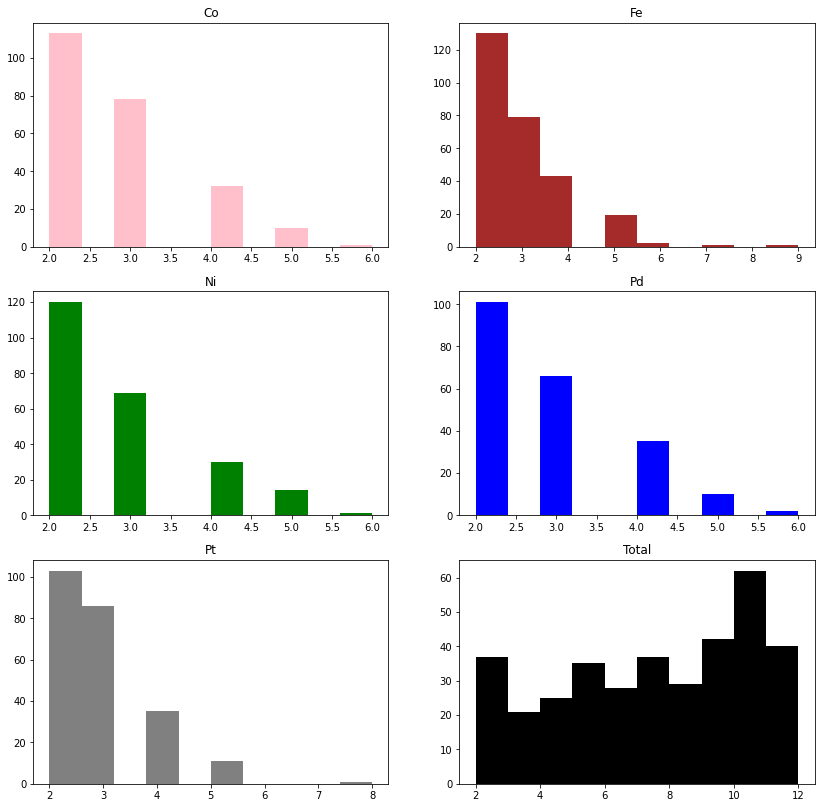

In [21]:
colors = ['pink','brown','green','blue','gray','black']

fig = plt.figure(figsize=(14, 14))


for cs in range(len(chemical_symbols) + 1):
        
    ax = fig.add_subplot(3, 2, cs + 1)
    ax.hist(CHs_all_elements[cs],
                color = colors[cs])
 
    if cs < len(chemical_symbols):
        plt.title(chemical_symbols[cs])
    else:
        plt.title('Total')

## 2.2 Columns compositions.

Here we show a plot of the variation of column composition by elment, column by column. The column composition by element in a column is calculated as the fraction of the CH of that element in that column and the total CH of that column.

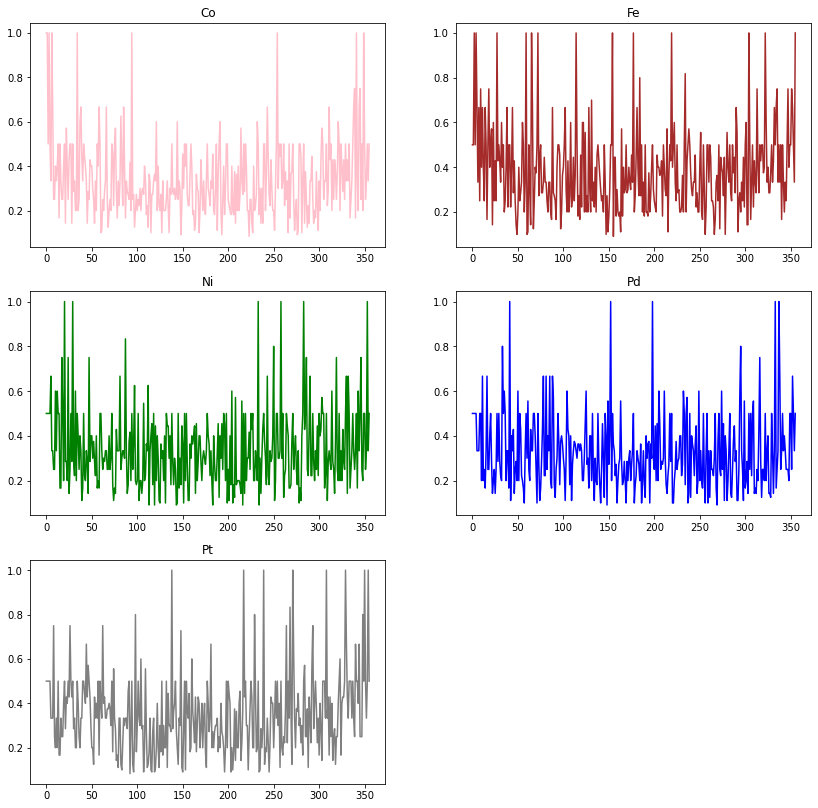

In [22]:
peaks_pos = get_peaks_pos(np.sum(lbl,axis = 2))
CHs_tot =  np.round(np.sum(lbl,axis = 2)[peaks_pos[:,0],peaks_pos[:,1]]) + 1

colors = ['pink','brown','green','blue','gray']

fig = plt.figure(figsize=(14, 14))

for cs in range(1,len(chemical_symbols) + 1):
    
    CHs = np.round(lbl[peaks_pos[:,0],peaks_pos[:,1],cs - 1]) + 1
        
    ax = fig.add_subplot(3, 2, cs)
    ax.plot(CHs/CHs_tot, c = colors[cs - 1])
    plt.title(chemical_symbols[cs - 1])

## 2.3 STEM Intensity-CHs correlations

We study the correlations between the pixel intensities in the simulated HAADF STEM images and the CHs for each chemical element. The correlation is investigated with a scatterplot with the STEM intensity of the columns in the y axis and the CHs of a chemical element on the x axis. The correlation is also analyzed for the total column heights (sum of column heights of each element).

We perform a linear fit of the I-CHs correlation in order to compare with a typical linear STEM relationship. The R2 of the linear fit indicates how much the correlation deviates from a linear profile, while the slope suggests about the tendency of an increased intensity for higher CHs. The linear fit is performed using the **LinearRegression** class from the **Scikit-Learn** library for Machine Learning algorithms.

In [23]:
from skimage.feature import peak_local_max
from sklearn.linear_model import LinearRegression

In [24]:
I_all_elements = []
CHs_all_elements = []
slope_all_elements = []
intercept_all_elements = []
R2_all_elements = []

# STEM intensity - column heights correlation by element
for ce in range(lbl.shape[2]):
    
    peaks_pos = get_peaks_pos(lbl[:,:,ce])
    I = img[peaks_pos[:,0],peaks_pos[:,1]] 
    CHs =  np.round(lbl[peaks_pos[:,0],peaks_pos[:,1],ce]) + 1
    
    lr = LinearRegression()
    lr.fit(CHs.reshape(-1,1),I.reshape(-1,1))
    slope = lr.coef_[0][0]
    interecept = lr.intercept_[0]
    
    R2 = lr.score(I.reshape(-1,1), 
                   CHs.reshape(-1,1))
    
    I_all_elements.append(I)
    CHs_all_elements.append(CHs)
    
    slope_all_elements.append(slope)
    intercept_all_elements.append(interecept)
    
    R2_all_elements.append(R2)
    

# STEM intensity - total column heights correlation 
peaks_pos = get_peaks_pos(np.sum(lbl,axis = 2))
I = img[peaks_pos[:,0],peaks_pos[:,1]] 
CHs =  np.round(np.sum(lbl,axis = 2)[peaks_pos[:,0],peaks_pos[:,1]]) + 1

lr = LinearRegression()
lr.fit(CHs.reshape(-1,1),I.reshape(-1,1))
slope = lr.coef_[0][0]
intercept = lr.intercept_[0]

R2 = lr.score(I.reshape(-1,1), 
               CHs.reshape(-1,1))

I_all_elements.append(I)
CHs_all_elements.append(CHs)

slope_all_elements.append(slope)
intercept_all_elements.append(interecept)

R2_all_elements.append(R2)

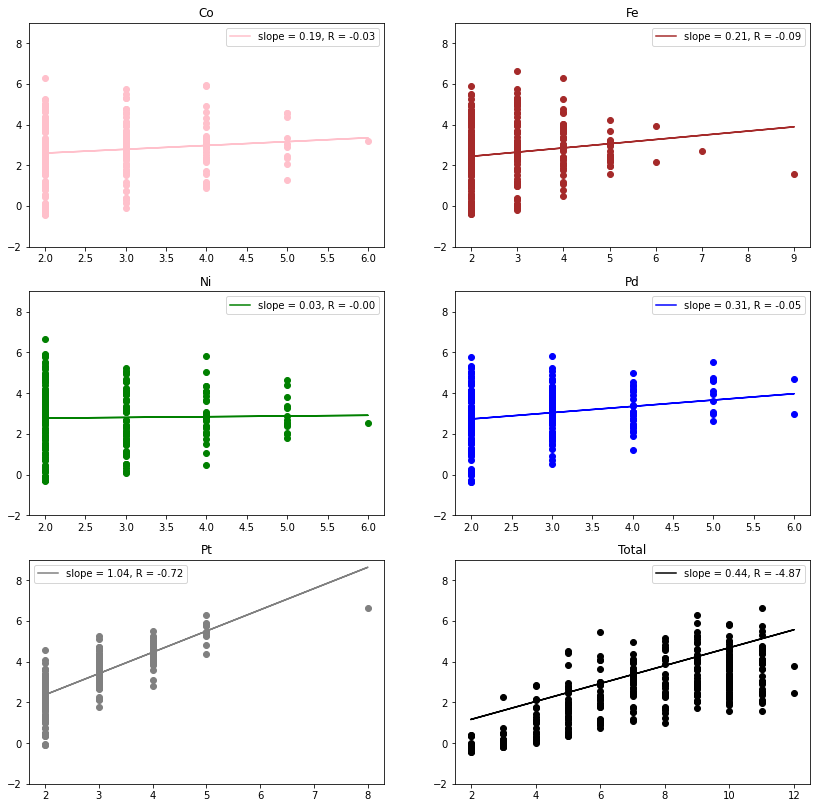

In [25]:
colors = ['pink','brown','green','blue','gray','black']

fig = plt.figure(figsize=(14, 14))


for cs in range(len(chemical_symbols) + 1):
        
    ax = fig.add_subplot(3, 2, cs + 1)
    ax.scatter(CHs_all_elements[cs],
                I_all_elements[cs],
                c = colors[cs])
    ax.plot(CHs_all_elements[cs], 
            slope_all_elements[cs] * CHs_all_elements[cs] + intercept_all_elements[cs],
            c = colors[cs])
    ax.set_ylim(-2, 9)
    
    if cs < len(chemical_symbols):
        plt.title(chemical_symbols[cs])
    else:
        plt.title('Total')
        
    plt.legend(['slope = {:.2f}, R = {:.2f}'.format(slope_all_elements[cs], 
                                                    R2_all_elements[cs])])
    

# 3. Model Prediction

The final objective of this study is to predict the CHs of each chemical element in the HEA using a deep learning model trained on simulated STEM images. Here we plot the model's prediction and we evaluate the R2 score between the predicted and the true CHs. We use the R2 because we predict the CHs using a regression based neural network (the CHs are represented with segmentation maps using Gaussian distributions with continuous values).

In [ ]:
sys.path.append('../deep_learning/tensorflow2.2/scripts/')

import tensorflow as tf

from fcn import FCN
from training_utils import R2_CHs,Random_Imaging,plot_debug

def plot_prediction(img,lbl,pred,cs):
    
    if len(img.shape) == 4:
        img = img[0,:,:,0]
    
    i = np.where(np.array(['Fe','Mn','O']) == cs)[0][0]
    
        
    fig = plt.figure(figsize=(28, 14))

    ax = fig.add_subplot(1, 3, 1)
    im = ax.imshow(img, cmap='gray')
    plt.title('Simulated STEM image', fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)

    ax = fig.add_subplot(1, 3, 2)
    im = ax.imshow(pred[0,:,:,i], cmap='jet')
    plt.title('{} CHs Prediction'.format(cs), fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)

    ax = fig.add_subplot(1, 3, 3)
    im = ax.imshow(lbl[:,:,i], cmap='jet')
    plt.title('{} CHs Ground Truth'.format(cs), fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)

    r2_CHs = R2_CHs(pred, lbl.reshape((1,) + lbl.shape))
    r2 = r2_CHs.get_r2_all_elements_batch()
    

    print('R2: {:.3f}'.format(r2[i]))

def make_model(FCN,input_shape,input_channel,output_channels):
    
    
    input_tensor = tf.keras.Input(shape = input_shape+(input_channel,))

    model = FCN(input_tensor, output_channels)

    return model


In [ ]:
input_channel = 1
input_shape = (256,256)
output_channels = 2

model = make_model(FCN, input_shape,input_channel,output_channels)

model.load_weights('path/to/weights/')

In [ ]:
rnd = True

if rnd:
    rnd_imgn = Random_Imaging(image = img.reshape((1,) + img.shape + (1,)),
                                              labels = lbl.reshape((1,) + lbl.shape))
    img_rnd,lbl = rnd_imgn.get_transform()
    lbl = lbl[0,:,:,:]
else:
    img_rnd = img.reshape((1,) + img.shape + (1,))



pred = model(img_rnd, training = True)

In [ ]:
plot_prediction(img_rnd,lbl,pred, cs = 'Fe')